In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Przygotowanie danych. 

In [17]:
dir_path = "D:/Python/Projekty/Moje_projekty/Pneumonia/input"
train_p = os.path.join(dir_path, "train")

In [18]:
''' PNEUMONIA images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")
train_p = os.path.join(dir_path, "train")
test_p =os.path.join(dir_path, "test")
val_p = os.path.join(dir_path, "val")

In [21]:
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [28]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

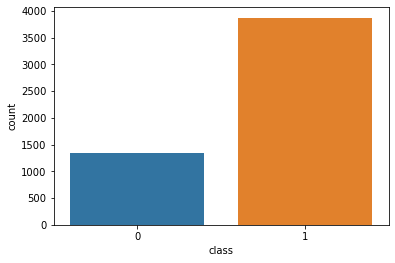

In [30]:
import seaborn as sns
sns.countplot(df['class'],data=df)

In [45]:
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')


In [44]:
'''val_datagen jest generatorem transformacji danych, który normalizuje wartości pikseli w 
zbiorze walidacyjnym poprzez rescale=1/255, ale nie stosuje innych transformacji danych.'''
val_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [37]:
model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

58889256/58889256 [==============================] - 9s 0us/step


In [38]:
''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

In [39]:
lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

In [40]:
''' lets see how model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [46]:
train_ds = train_ds.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_ds.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')

tes_ds = val_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [47]:
''' training '''
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 107s 1s/step - loss: 2.4891 - accuracy: 0.7625 - val_loss: 0.5789 - val_accuracy: 0.6875
Epoch 2/20
100/100 [==============================] - 102s 1s/step - loss: 0.4507 - accuracy: 0.8444 - val_loss: 1.2058 - val_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 113s 1s/step - loss: 0.4938 - accuracy: 0.8350 - val_loss: 0.3072 - val_accuracy: 0.8750
Epoch 4/20
100/100 [==============================] - 112s 1s/step - loss: 0.2996 - accuracy: 0.8888 - val_loss: 1.0905 - val_accuracy: 0.6875
Epoch 5/20
100/100 [==============================] - 107s 1s/step - loss: 0.2864 - accuracy: 0.8863 - val_loss: 0.3647 - val_accuracy: 0.8125
Epoch 6/20
100/100 [==============================] - 112s 1s/step - loss: 0.3008 - accuracy: 0.8863 - val_loss: 0.2992 - val_accuracy: 0.9375
Epoch 7/20
100/100 [==============================] - 129s 1s/step - loss: 0.2605 - accuracy: 0.9031 - val_loss: 0.2815 - val_accuracy: 0.9375

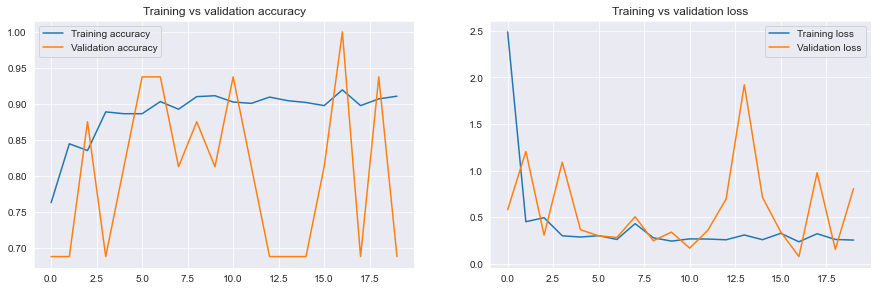

In [49]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [50]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Number of GPUs Available: ", len(physical_devices))

Number of GPUs Available:  0


In [51]:
tf.config.list_physical_devices('GPU')

[]